In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic') # 맑은 고딕으로 글꼴 설정하기
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False # 마이너스 기호 문제 해결하기
import seaborn as sns
from scipy import stats
import plotly.express as px

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from lightgbm import plot_importance
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

### 컬럼 설명

- system_id	: system 상 id
- grade_sect_cd	: 학년 (1~6학년)
- mbr_sex_cd : 성별
- tmon_pchrg_lrn_dcnt : 당월 유료 학습 일 수
- acmlt_pchrg_lrn_dcnt : 누적 유료 학습 일 수 (성숙도)
- acmlt_bilclct_amt	: 누적 수금액
- correct_rate_avg	: 당월 획득 점수 평균
- learning_time_avg	: 당월 학습 시간 평균
- media_action_cnt_sum : 미디어 콘텐츠 내 동영상 행동 횟수 (총합)
- non_video_viewed_cnt_sum : 미디어 콘텐츠 미시청 행동 횟수 (총합)
- get_mm_point_sum : 당월 획득 포인트 합 (사용 x)
- label	: 이탈, 미이탈 여부 (0 - 미이탈, 1 - 이탈)
- re_purch : 신규, 재구매 여부 (False - 신규, True - 재구매)

In [5]:
# 데이터 읽어오기
import pandas as pd
df = pd.read_csv('churn_data.csv')
df = df.drop(columns=['number']) # 필요없는 컬럼 제거
df = df.fillna(0) # 결측치 0처리

# 성별 변환 함수
def change_sex(values):
    if values == 'M': # 남성 = 0
        return 0
    elif values == 'F': # 여성 = 1
        return 1
    else:
        return 2 # 알 수 없음 = 2
    
# 성별 치환 (숫자로, 남성-0, 여성-1, 알 수 없음-2)
df['sex'] = df['mbr_sex_cd'].apply(lambda x: change_sex(x))

# 학년 치환 (숫자로)
df['grade'] = df['grade_sect_cd'].apply(lambda x:int(x.split('G01')[1]))

In [6]:
# 모델 구성
def df_model(sex_df, sex_name = '남성'):
    
    X = sex_df[['tmon_pchrg_lrn_dcnt',
                'acmlt_pchrg_lrn_dcnt',
                'acmlt_bilclct_amt',
                'correct_rate_avg',
                'learning_time_avg',
                'media_action_cnt_sum',
                'non_video_viewed_cnt_sum',
                'get_mm_point_sum']]
    
    y = sex_df['label']
    
    # Train, Test 데이터 분리 (이탈 미이탈 값 확인)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print('[Train] {} : {}, 이탈 : {}, 미이탈 : {}'.format(sex_name, len(X_train), y_train[y_train == 1].shape[0], y_train[y_train == 0].shape[0]))
    print('[Test] {} : {}, 이탈 : {}, 미이탈 : {}'.format(sex_name, len(X_test), y_test[y_test == 1].shape[0], y_test[y_test == 0].shape[0]))  
    
    # LGBM 모델 학습
    lgbm_model = LGBMClassifier(random_state=0, verbose=-1)
    lgbm_model.fit(X_train, y_train)
    
    # 예측 결과
    y_pred = lgbm_model.predict(X_test)
    y_pred = list(y_pred)
    print('[Predict] 이탈 : {}, 미이탈 : {}'.format(y_pred.count(1), y_pred.count(0)))
    
    # Accuracy 측정
    acc = accuracy_score(y_test, y_pred)
    
    # precision, recall, f1 score 측정
    pre, re, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    print('{}, acc: {}, precision: {}, recall: {}, f1: {}'.format(sex_name, acc, pre, re, f1))
    
    # 변수 시각화
    fig, ax = plt.subplots(figsize=(5,5))
    plot_importance(lgbm_model, ax=ax)
    plt.title('{} Feature Importance'.format(sex_name))
    plt.show()
    print('\n')

    return

[Train] 남성 : 26274, 이탈 : 441, 미이탈 : 25833
[Test] 남성 : 6569, 이탈 : 92, 미이탈 : 6477
[Predict] 이탈 : 88, 미이탈 : 6481
남성, acc: 0.9951286344953569, precision: 0.8409090909090909, recall: 0.8043478260869565, f1: 0.8222222222222223


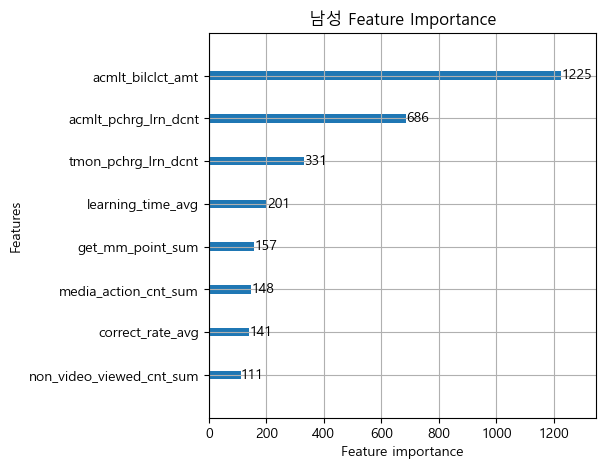



[Train] 여성 : 20352, 이탈 : 299, 미이탈 : 20053
[Test] 여성 : 5089, 이탈 : 78, 미이탈 : 5011
[Predict] 이탈 : 62, 미이탈 : 5027
여성, acc: 0.9921399096089605, precision: 0.8064516129032258, recall: 0.6410256410256411, f1: 0.7142857142857142


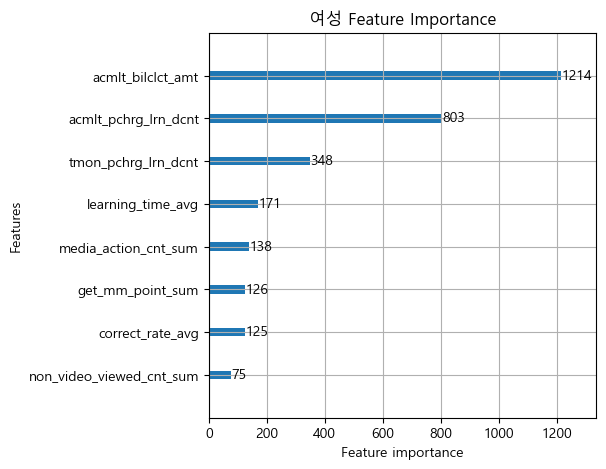

In [7]:
# 성별 변환 함수2
def change_sex2(values):
    if values == 0: # 남성 = 0
        return '남성'
    elif values == 1: # 여성 = 1
        return '여성'
    else:
        return '알 수 없음' # 알 수 없음 = 2
    
# 실행부 구성
for sex in range(0, 2):
    sex_df = df[df['sex'] == sex]
    df_model(sex_df, sex_name = change_sex2(sex))

## 성능 지표

In [9]:
# 데이터 읽어오기 및 전처리
import pandas as pd
data = pd.read_csv('churn_data.csv')
data = data.drop(columns=['number'])
data = data.fillna(0)
data['sex'] = data['mbr_sex_cd'].apply(lambda x: change_sex(x))
data['grade'] = data['grade_sect_cd'].apply(lambda x:int(x.split('G01')[1]))

In [10]:
# 필요 컬럼만 가져오기
X = data[['tmon_pchrg_lrn_dcnt',
                'acmlt_pchrg_lrn_dcnt',
                'acmlt_bilclct_amt',
                'correct_rate_avg',
                'learning_time_avg',
                'media_action_cnt_sum',
                'non_video_viewed_cnt_sum',
                'get_mm_point_sum']]
    
y = data['label']

In [11]:
# 데이터 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('[Train] 전체 : {}, 이탈 : {}, 미이탈 : {}'.format(len(X_train), y_train[y_train == 1].shape[0], y_train[y_train == 0].shape[0]))
print('[Test] 전체 : {}, 이탈 : {}, 미이탈 : {}'.format(len(X_test), y_test[y_test == 1].shape[0], y_test[y_test == 0].shape[0]))     

[Train] 전체 : 48000, 이탈 : 746, 미이탈 : 47254
[Test] 전체 : 12000, 이탈 : 186, 미이탈 : 11814


In [12]:
# LGBM 모델 학습
lgbm_model = LGBMClassifier(random_state=0, verbose=-1)
lgbm_model.fit(X_train, y_train)

LGBMClassifier(random_state=0, verbose=-1)

In [13]:
# 예측
y_pred = lgbm_model.predict(X_test)
y_pred = list(y_pred)
print('[Predict] 이탈 : {}, 미이탈 : {}'.format(y_pred.count(1), y_pred.count(0)))

[Predict] 이탈 : 166, 미이탈 : 11834


In [14]:
# Accuracy 측정
accuracy_score(y_test, y_pred)

0.9945

In [15]:
# precision, recall, f1 score 측정
precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.8614457831325302, 0.7688172043010753, 0.8125, None)

In [16]:
cm = confusion_matrix(y_test, y_pred)
cm

# [[TN, FP],
# [FN, TP]]

array([[11791,    23],
       [   43,   143]], dtype=int64)

In [17]:
# cmtx 구성
cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels = [1,0]),
    index = ['실제: 이탈 (1)', '실제: 미이탈(0)'],
    columns = ['예측: 이탈 (1)', '예측: 미이탈(0)']
)

cmtx

# [[TP, FN],
# [FP, TN]]

,예측: 이탈 (1),예측: 미이탈(0)
실제: 이탈 (1),143,43
실제: 미이탈(0),23,11791


<Axes: title={'center': 'Confusion Matrix'}>

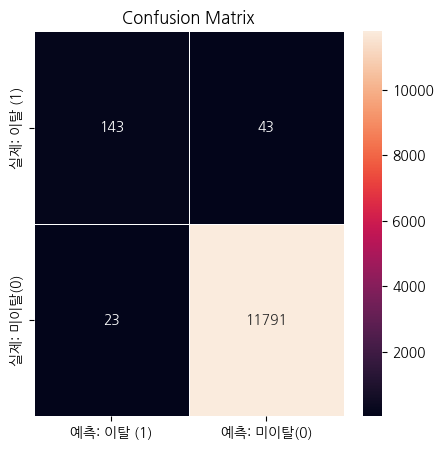

In [18]:
# cmtx 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib # 한글 폰트 안 깨지고 사용 가능

plt.figure(figsize=(5,5))
plt.title('Confusion Matrix')
sns.heatmap(cmtx, annot=True, fmt='.0f', linewidth=.5)

In [19]:
# TP(0,0), FP(1,0), FN(0,1), TN(1,1)


# Precision
# TP / (TP+FP) (0,0), (1,0)
precision = cmtx.iloc[0,0] / (cmtx.iloc[0,0] + cmtx.iloc[1,0])

# Recall
# TP /(TP+FN)
recall = cmtx.iloc[0,0] / (cmtx.iloc[0,0] + cmtx.iloc[0,1])


# F1 Score
# 2 * (Precision * Recall)/(Precision + Recall)
f1 = 2 * (precision * recall)/(precision + recall)

print('precision: {}, recall: {}, f1: {}'.format(precision, recall, f1))

precision: 0.8614457831325302, recall: 0.7688172043010753, f1: 0.8125
